In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import stats
import re

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_style("whitegrid")

In [3]:
# Define file paths (adjust these paths according to your setup)
fake_path = "/content/Fake.csv"  # For Colab
true_path = "/content/True.csv"  # For Colab

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add labels
fake_df['label'] = 0  # Fake news
true_df['label'] = 1  # True news

# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

print(f"Fake news articles: {len(fake_df)}")
print(f"True news articles: {len(true_df)}")
print(f"Combined dataset shape: {df.shape}")

Fake news articles: 23481
True news articles: 21417
Combined dataset shape: (44898, 5)


In [4]:
print("Dataset columns:", list(df.columns))
print(f"\nDataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset columns: ['title', 'text', 'subject', 'date', 'label']

Dataset shape: (44898, 5)

Data types:
title      object
text       object
subject    object
date       object
label       int64
dtype: object

Missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [5]:
# Check duplicates
duplicates_all = df.duplicated().sum()
duplicates_content = df.duplicated(subset=['title', 'text']).sum()

print(f"Duplicates (all columns): {duplicates_all}")
print(f"Duplicates (title + text): {duplicates_content}")

# Class distribution
class_counts = df['label'].value_counts().sort_index()
class_props = df['label'].value_counts(normalize=True).sort_index() * 100

print(f"\nClass distribution:")
print(f"Fake (0): {class_counts[0]} ({class_props[0]:.1f}%)")
print(f"Real (1): {class_counts[1]} ({class_props[1]:.1f}%)")

# Subject distribution if available
if 'subject' in df.columns:
    print(f"\nSubject categories:")
    print(df['subject'].value_counts())

Duplicates (all columns): 209
Duplicates (title + text): 5793

Class distribution:
Fake (0): 23481 (52.3%)
Real (1): 21417 (47.7%)

Subject categories:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [6]:
# Fill missing values
df['text'] = df['text'].fillna("")
df['title'] = df['title'].fillna("")

# Word counts
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

# Character counts
df['text_char_count'] = df['text'].apply(len)
df['title_char_count'] = df['title'].apply(len)

# Sentence counts (approximate)
df['text_sentence_count'] = df['text'].apply(lambda x: len(re.split(r'[.!?]+', str(x))))

# Average word length
df['avg_word_length'] = df['text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0
)

# Uppercase ratio
df['uppercase_ratio'] = df['text'].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

# Display statistics for new features
text_features = ['text_word_count', 'title_word_count', 'text_char_count',
                'title_char_count', 'avg_word_length', 'uppercase_ratio']

print("Text feature statistics:")
print(df[text_features].describe())

Text feature statistics:
       text_word_count  title_word_count  text_char_count  title_char_count  \
count     44898.000000      44898.000000     44898.000000      44898.000000   
mean        405.282284         12.453472      2469.109693         80.111720   
std         351.265595          4.111476      2171.617091         25.379685   
min           0.000000          1.000000         1.000000          8.000000   
25%         203.000000         10.000000      1234.000000         63.000000   
50%         362.000000         11.000000      2186.000000         73.000000   
75%         513.000000         14.000000      3105.000000         91.000000   
max        8135.000000         42.000000     51794.000000        286.000000   

       avg_word_length  uppercase_ratio  
count     44898.000000     44898.000000  
mean          5.090994         0.043705  
std           2.175507         0.034819  
min           0.000000         0.000000  
25%           4.855334         0.030493  
50%        

In [7]:
features = ['text_word_count', 'title_word_count', 'avg_word_length', 'uppercase_ratio']

for feature in features:
    fake_values = df[df['label'] == 0][feature]
    real_values = df[df['label'] == 1][feature]

    # T-test
    statistic, p_value = stats.ttest_ind(fake_values, real_values)

    print(f"\n{feature}:")
    print(f"  Fake news - Mean: {fake_values.mean():.2f}, Std: {fake_values.std():.2f}")
    print(f"  Real news - Mean: {real_values.mean():.2f}, Std: {real_values.std():.2f}")
    print(f"  T-test p-value: {p_value:.2e}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")


text_word_count:
  Fake news - Mean: 423.20, Std: 408.39
  Real news - Mean: 385.64, Std: 274.01
  T-test p-value: 1.00e-29
  Significant difference: Yes

title_word_count:
  Fake news - Mean: 14.73, Std: 4.34
  Real news - Mean: 9.95, Std: 1.70
  T-test p-value: 0.00e+00
  Significant difference: Yes

avg_word_length:
  Fake news - Mean: 5.01, Std: 3.00
  Real news - Mean: 5.18, Std: 0.26
  T-test p-value: 1.08e-15
  Significant difference: Yes

uppercase_ratio:
  Fake news - Mean: 0.05, Std: 0.05
  Real news - Mean: 0.04, Std: 0.02
  T-test p-value: 2.32e-30
  Significant difference: Yes


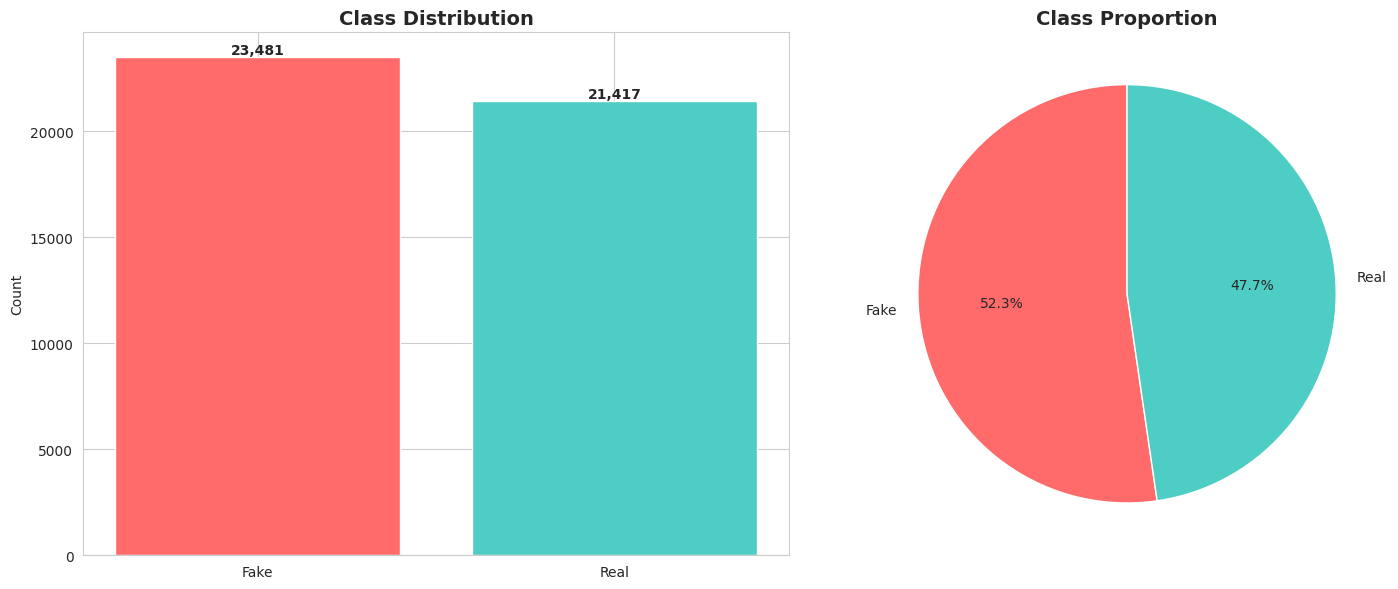

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
class_counts = df['label'].value_counts().sort_index()
bars = ax1.bar(['Fake', 'Real'], class_counts.values, color=['#ff6b6b', '#4ecdc4'])
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')

# Add count annotations
for bar, count in zip(bars, class_counts.values):
    ax1.annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie(class_counts.values, labels=['Fake', 'Real'], autopct='%1.1f%%',
        colors=['#ff6b6b', '#4ecdc4'], startangle=90)
ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

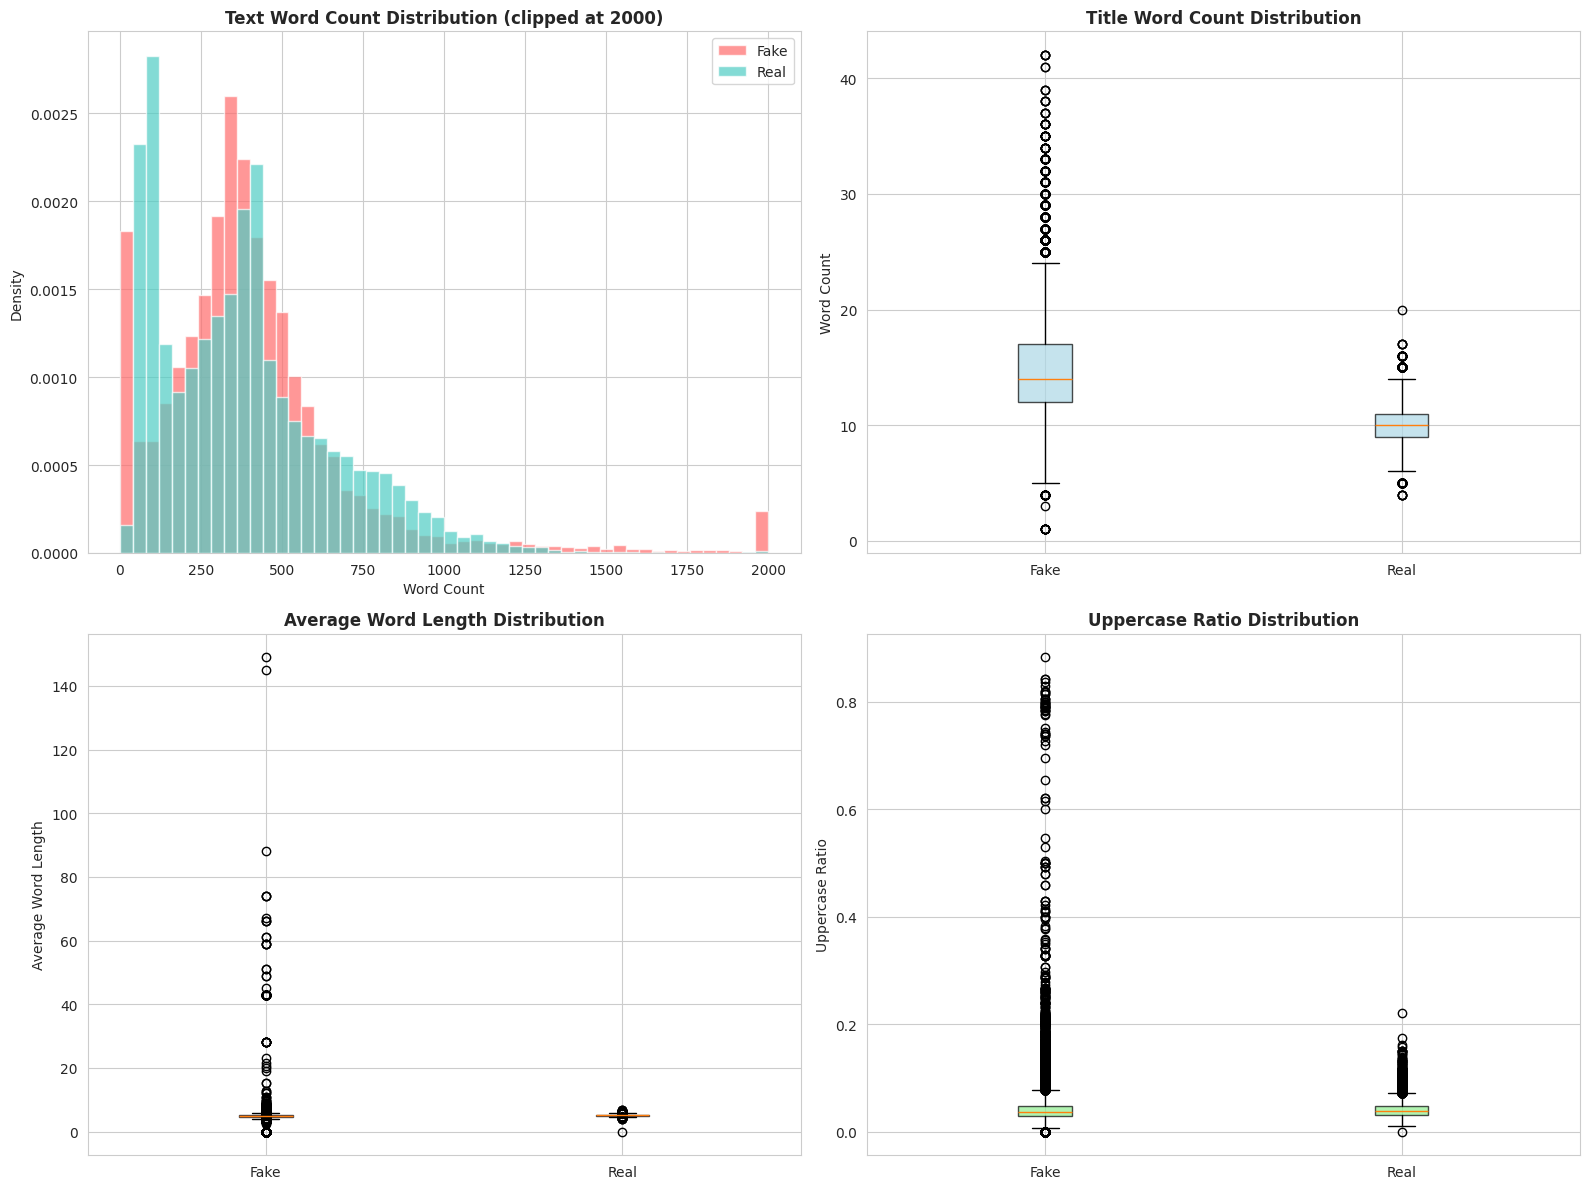

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Text word count distribution
fake_text_words = df[df['label'] == 0]['text_word_count']
real_text_words = df[df['label'] == 1]['text_word_count']

axes[0,0].hist(fake_text_words.clip(upper=2000), bins=50, alpha=0.7, label='Fake', color='#ff6b6b', density=True)
axes[0,0].hist(real_text_words.clip(upper=2000), bins=50, alpha=0.7, label='Real', color='#4ecdc4', density=True)
axes[0,0].set_title('Text Word Count Distribution (clipped at 2000)', fontweight='bold')
axes[0,0].set_xlabel('Word Count')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()

# Title word count boxplot
title_data = [df[df['label'] == 0]['title_word_count'],
             df[df['label'] == 1]['title_word_count']]
axes[0,1].boxplot(title_data, labels=['Fake', 'Real'], patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0,1].set_title('Title Word Count Distribution', fontweight='bold')
axes[0,1].set_ylabel('Word Count')

# Average word length comparison
avg_word_data = [df[df['label'] == 0]['avg_word_length'],
                df[df['label'] == 1]['avg_word_length']]
axes[1,0].boxplot(avg_word_data, labels=['Fake', 'Real'], patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7))
axes[1,0].set_title('Average Word Length Distribution', fontweight='bold')
axes[1,0].set_ylabel('Average Word Length')

# Uppercase ratio comparison
upper_data = [df[df['label'] == 0]['uppercase_ratio'],
             df[df['label'] == 1]['uppercase_ratio']]
axes[1,1].boxplot(upper_data, labels=['Fake', 'Real'], patch_artist=True,
                 boxprops=dict(facecolor='lightgreen', alpha=0.7))
axes[1,1].set_title('Uppercase Ratio Distribution', fontweight='bold')
axes[1,1].set_ylabel('Uppercase Ratio')

plt.tight_layout()
plt.savefig('text_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

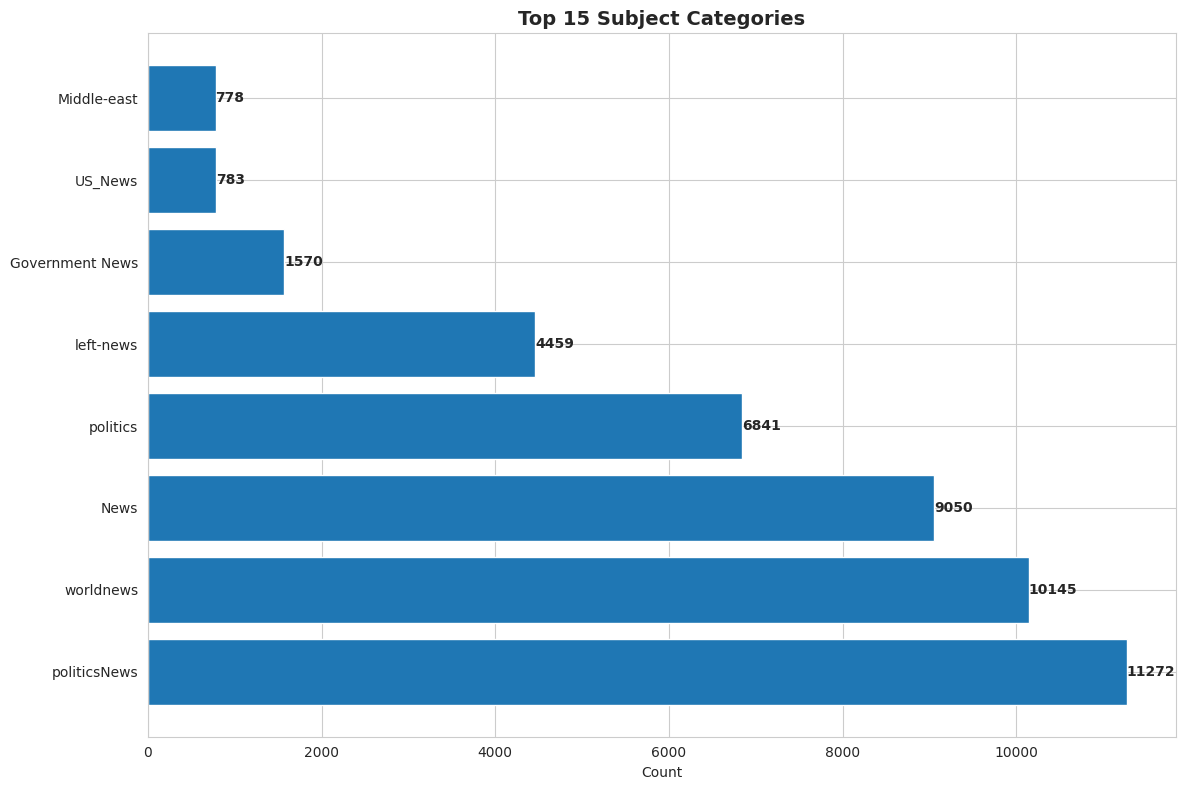

In [10]:
if 'subject' in df.columns:
    plt.figure(figsize=(12, 8))
    subject_counts = df['subject'].value_counts().head(15)

    # Create horizontal bar plot
    bars = plt.barh(range(len(subject_counts)), subject_counts.values)
    plt.yticks(range(len(subject_counts)), subject_counts.index)
    plt.xlabel('Count')
    plt.title('Top 15 Subject Categories', fontsize=14, fontweight='bold')

    # Add count annotations
    for i, (bar, count) in enumerate(zip(bars, subject_counts.values)):
        plt.annotate(f'{count}', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                    ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('subject_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
# Most frequent words overall
vectorizer = CountVectorizer(stop_words='english', max_features=20, lowercase=True)
X = vectorizer.fit_transform(df['text'].fillna('').astype(str))

word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'count': np.array(X.sum(axis=0)).flatten()
}).sort_values('count', ascending=False)

print("Top 20 most frequent words (excluding stop words):")
print(word_freq)

Top 20 most frequent words (excluding stop words):
          word   count
16       trump  134000
12        said  132825
9    president   55892
8       people   41857
13       state   34488
6          new   31311
11     reuters   29425
0      clinton   28695
7        obama   28203
1       donald   28127
2   government   28048
3        house   27753
14      states   26843
10  republican   25568
19        year   24998
4         just   24967
17      united   23601
15        told   23367
5         like   22774
18       white   22745


In [12]:
fake_text = ' '.join(df[df['label'] == 0]['text'].fillna('').astype(str))
real_text = ' '.join(df[df['label'] == 1]['text'].fillna('').astype(str))

# TF-IDF analysis for fake news
tfidf_fake = TfidfVectorizer(stop_words='english', max_features=10)
fake_tfidf = tfidf_fake.fit_transform([fake_text])
fake_feature_names = tfidf_fake.get_feature_names_out()
fake_scores = fake_tfidf.toarray()[0]
fake_top_words = pd.DataFrame({
    'word': fake_feature_names,
    'tfidf_score': fake_scores
}).sort_values('tfidf_score', ascending=False)

# TF-IDF analysis for real news
tfidf_real = TfidfVectorizer(stop_words='english', max_features=10)
real_tfidf = tfidf_real.fit_transform([real_text])
real_feature_names = tfidf_real.get_feature_names_out()
real_scores = real_tfidf.toarray()[0]
real_top_words = pd.DataFrame({
    'word': real_feature_names,
    'tfidf_score': real_scores
}).sort_values('tfidf_score', ascending=False)

print("Top words in FAKE news (TF-IDF):")
print(fake_top_words)

print("\nTop words in REAL news (TF-IDF):")
print(real_top_words)

Top words in FAKE news (TF-IDF):
        word  tfidf_score
9      trump     0.759638
8       said     0.323426
7  president     0.265490
6     people     0.254522
2       just     0.196481
0    clinton     0.183664
5      obama     0.180062
3       like     0.173356
1     donald     0.169276
4       news     0.140049

Top words in REAL news (TF-IDF):
         word  tfidf_score
6        said     0.774955
9       trump     0.427914
5     reuters     0.226677
3   president     0.220427
7       state     0.164477
0  government     0.147431
2         new     0.132340
8      states     0.130267
1       house     0.130174
4  republican     0.127068
